# Билет 25

## Задание 2

In [15]:
import matplotlib.pyplot as plt
import torch
import random

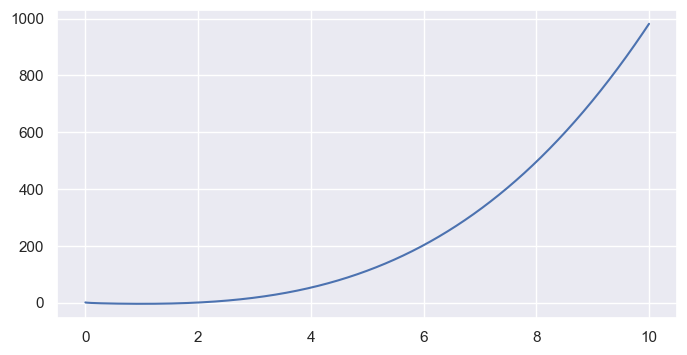

In [16]:
f = lambda x: x ** 3 - 6 * torch.sqrt(x) + 1
start, end = 0, 10
X = torch.arange(start, end + 0.001, 0.001)
Y = f(X)
plt.plot(X.detach(), Y.detach());

Оптимизация с помощью градиентного спуска:

In [17]:
x = torch.tensor(random.uniform(start, end), dtype=torch.float, requires_grad=True)

xs = []
while True:
    xs.append(x.detach().clone())
    y = f(x)
    y.backward()
    with torch.no_grad():
        x -= 0.01 * x.grad  # learning rate градиентного спуска
        if torch.abs(x - xs[-1]) <= 0.0000001:  # точность поиска
            xs.append(x.detach().clone())
            break
    x.grad.zero_()

Стартовая позиция: x=2.296164, y=4.014361
Локальный минимум: x=1.000001, f(x)=-4.000000


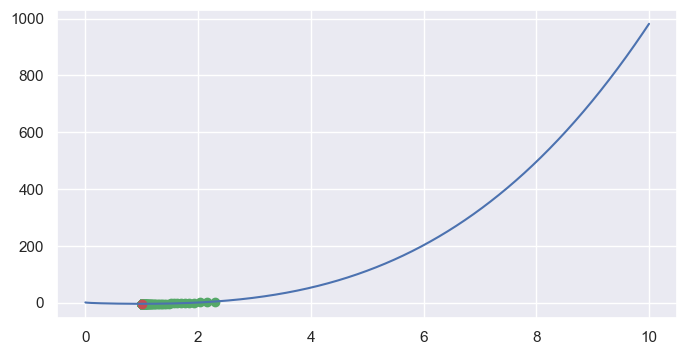

In [18]:
x, y = x.item(), f(x).item()
print(f"Стартовая позиция: x={xs[0]:5f}, y={f(xs[0]):5f}")
print(f"Локальный минимум: {x=:5f}, f(x)={y:5f}")
plt.plot(X.detach(), Y.detach())
plt.scatter(xs, f(torch.tensor(xs)), color="g")
plt.scatter(x, y, color="r");

## Задание 3

In [19]:
import re
from collections import defaultdict

import matplotlib.pyplot as plt
import nltk
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from nltk.corpus import wordnet, stopwords
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [20]:
%matplotlib inline

Скачивание данных для nltk:

In [21]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\super\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\super\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\super\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\super\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\super\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [22]:
sns.set_theme()
plt.rcParams["figure.figsize"] = (8, 4)

In [23]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {DEVICE.upper()} device")

Using CUDA device


In [24]:
def get_pos(word):  # перевод из nltk тегов в wordnet
    tag = nltk.pos_tag([word])[0][1]
    if tag.startswith("J"):
        return wordnet.ADJ
    elif tag.startswith("V"):
        return wordnet.VERB
    elif tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN


wordnet_lemmatizer = nltk.WordNetLemmatizer()

RE_URL = re.compile(r"\w+://\S+", flags=re.MULTILINE)
RE_NOT_ASCII_LOW = re.compile(r"[^a-z]", flags=re.MULTILINE)
STOPWORDS = set(stopwords.words("english"))


def preprocess_text(text, lemmatizer, min_word_len):
    text = text.lower()
    for pat in [RE_URL, RE_NOT_ASCII_LOW]:  # удаление URL'ов, а затем всех не буквенных символов
        text = pat.sub(" ", text)

    words = []
    for word in nltk.word_tokenize(text):
        if word not in STOPWORDS and len(word) >= min_word_len:
            word = lemmatizer.lemmatize(word, pos=get_pos(word))
            if word not in STOPWORDS and len(word) >= min_word_len:
                words.append(word)

    return " ".join(words)


class WordVocab:
    pad = "<PAD>"
    unknown = "<UNK>"

    def __init__(self, texts):
        uniques = set()
        max_len = 0
        for text in texts:
            words = nltk.word_tokenize(text)
            uniques.update(words)
            max_len = max(len(words), max_len)

        self.alphabet = [self.pad, self.unknown, *uniques]
        self.max_len = max_len

        w2i = {w: i for i, w in enumerate(self.alphabet)}
        unknown_idx = w2i[self.unknown]
        self.w2i = defaultdict(lambda: unknown_idx, w2i)

    def __len__(self):
        return len(self.alphabet)

    def encode(self, text):
        indices = [self.w2i[w] for w in nltk.word_tokenize(text)]
        indices += [self.w2i[self.pad]] * (self.max_len - len(indices))
        return torch.tensor(indices, dtype=torch.long)

    def decode(self, indices):
        pad_indices = torch.nonzero(indices == self.w2i[self.pad], as_tuple=True)[0]  # noqa
        if len(pad_indices):
            indices = indices[:pad_indices[0]]  # удаление <PAD>
        return " ".join(self.alphabet[i] for i in indices)

In [25]:
class ActivitiesDataset(Dataset):

    def __init__(self, df, vocab = None, encoder = None):
        self.raw_texts = df["Text"].tolist()
        with tqdm(total=len(df)) as pbar:
            self._pbar, self._i, self._n = pbar, 0, 100
            self.texts = [self.preprocess_text(text) for text in self.raw_texts]
        self.vocab = vocab or WordVocab(self.texts)

        if encoder:
            self.encoder = encoder
            encode = self.encoder.transform
        else:
            self.encoder = LabelEncoder()
            encode = self.encoder.fit_transform

        self.data = torch.vstack([self.vocab.encode(text) for text in self.texts])
        targets = encode(df["Review-Activity"])
        self.classes = self.encoder.classes_.tolist()
        self.targets = torch.tensor(targets, dtype=torch.long)

    def __len__(self):
        return self.data.size(0)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

    def preprocess_text(self, text):
        self._i += 1
        if self._i % self._n == 0:
            self._pbar.update(self._n)
        return preprocess_text(text, lemmatizer=wordnet_lemmatizer, min_word_len=3)

Выборка относительно сбалансированная:

ACTIVITY    5726
REVIEW      4274
Name: Review-Activity, dtype: int64


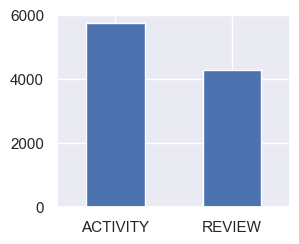

In [26]:
activities_df = pd.read_csv("../data/nlp/activities.csv")
vc = activities_df["Review-Activity"].value_counts()
print(vc)
activities_df["Review-Activity"].value_counts().plot.bar(rot=0, figsize=(3, 2.5));

Лемматизатор работает довольно долго, возможно лучше заменить его на стеммер:

In [27]:
# 80%/20%
train_df, test_df = train_test_split(activities_df, test_size=0.2, random_state=0)

train_dataset = ActivitiesDataset(train_df)
test_dataset = ActivitiesDataset(test_df, vocab=train_dataset.vocab, encoder=train_dataset.encoder)
print(len(train_dataset.vocab), train_dataset.vocab.max_len)
len(train_dataset), len(test_dataset), train_dataset.classes

100%|██████████| 2000/2000 [00:20<00:00, 98.83it/s] 


15364 87


(8000, 2000, ['ACTIVITY', 'REVIEW'])

In [28]:
def get_weights(targets):
    _, counts = targets.unique(return_counts=True)
    return counts.max() / counts


@torch.no_grad()
def get_y_true_y_pred(model, dataloader):
    model.eval()
    y_test = []
    y_pred = []
    for x, y in dataloader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        pred = model(x)
        y_test.append(y)
        y_pred.append(pred)
    return torch.flatten(torch.vstack(y_test)), torch.vstack(y_pred)

RNN классификатор на основе LSTM:

In [29]:
class ActivitiesRNNClassifier(nn.Module):
    rnn_state = None

    def __init__(self, num_embeddings, embedding_dim, rnn_hidden_size, vector_size, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim, padding_idx=0)
        self.rnn = nn.LSTM(input_size=embedding_dim, hidden_size=rnn_hidden_size, batch_first=True)
        self.classifier = nn.Sequential(
            nn.Linear(rnn_hidden_size * vector_size, 128),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(128, num_classes),
        )
        self.reset_rnn_state()

    def forward(self, x):
        x = self.embedding(x)

        x, rnn_state = self.rnn(x, self.rnn_state)
        self.keep_rnn_state(rnn_state)

        x = torch.flatten(x, 1)
        return self.classifier(x)

    def reset_rnn_state(self):
        self.rnn_state = None

    def keep_rnn_state(self, state):
        if isinstance(self.rnn, nn.LSTM):
            self.rnn_state = (state[0].detach(), state[1].detach())
        else:
            self.rnn_state = state.detach()

    def train(self, mode=True):
        self.reset_rnn_state()
        return super().train(mode)

Гиперпараметры: learning rate = 0.001, batch_size = 128 и параметры модели:

In [30]:
net = ActivitiesRNNClassifier(
    num_embeddings=len(train_dataset.vocab),
    embedding_dim=64,
    rnn_hidden_size=64,
    vector_size=train_dataset.vocab.max_len,
    num_classes=len(train_dataset.classes),
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss(weight=get_weights(train_dataset.targets).to(DEVICE))
optimizer = optim.Adam(net.parameters(), lr=0.001)

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=512, drop_last=True)

net

ActivitiesRNNClassifier(
  (embedding): Embedding(15364, 64, padding_idx=0)
  (rnn): LSTM(64, 64, batch_first=True)
  (classifier): Sequential(
    (0): Linear(in_features=5568, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=2, bias=True)
  )
)

Обучение модели:

In [31]:
%%time

train_losses, train_accuracy_list = [], []
test_losses, test_accuracy_list = [], []
for epoch in range(10):
    print(f"Epoch {epoch + 1}\n" + "-" * 32)

    net.train()
    num_batches = len(train_dataloader)
    avg_loss, avg_accuracy = 0, 0
    for batch, (x, y) in enumerate(train_dataloader):
        x, y = x.to(DEVICE), y.to(DEVICE)
        pred = net(x)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_true = torch.flatten(y).detach().cpu()
        y_pred = torch.flatten(pred.argmax(1)).detach().cpu()
        accuracy = metrics.accuracy_score(y_true, y_pred)
        avg_loss += loss
        avg_accuracy += accuracy
    train_loss, train_accuracy = (avg_loss / num_batches).item(), avg_accuracy / num_batches
    print(f"Train Error: loss: {train_loss:.6f}, accuracy: {train_accuracy:.4f}")
    train_losses.append(train_loss)
    train_accuracy_list.append(train_accuracy)

    net.eval()
    y_true, y_pred = get_y_true_y_pred(net, test_dataloader)
    test_loss, test_accuracy = loss_fn(y_pred, y_true).item(), metrics.accuracy_score(y_true.cpu(), y_pred.argmax(1).cpu())
    print(f" Test Error: loss: {test_loss:.6f}, accuracy: {test_accuracy:.4f}\n")
    test_losses.append(test_loss)
    test_accuracy_list.append(test_accuracy)

Epoch 1
--------------------------------
Train Error: loss: 0.175337, accuracy: 0.9389
 Test Error: loss: 0.047067, accuracy: 0.9818

Epoch 2
--------------------------------
Train Error: loss: 0.025674, accuracy: 0.9916
 Test Error: loss: 0.027129, accuracy: 0.9922

Epoch 3
--------------------------------
Train Error: loss: 0.009354, accuracy: 0.9974
 Test Error: loss: 0.026066, accuracy: 0.9928

Epoch 4
--------------------------------
Train Error: loss: 0.001768, accuracy: 0.9997
 Test Error: loss: 0.028818, accuracy: 0.9902

Epoch 5
--------------------------------
Train Error: loss: 0.001631, accuracy: 0.9996
 Test Error: loss: 0.028378, accuracy: 0.9922

Epoch 6
--------------------------------
Train Error: loss: 0.000910, accuracy: 0.9996
 Test Error: loss: 0.028444, accuracy: 0.9928

Epoch 7
--------------------------------
Train Error: loss: 0.000700, accuracy: 0.9999
 Test Error: loss: 0.035367, accuracy: 0.9915

Epoch 8
--------------------------------
Train Error: loss: 0.

Наблюдается незначительная проблема переобучения:

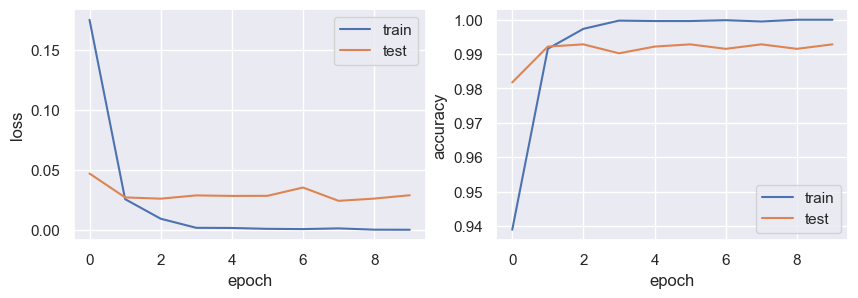

In [32]:
_, axes = plt.subplots(1, 2, figsize=(10, 3))
epochs = torch.arange(len(train_losses))

axes[0].plot(epochs, train_losses)
axes[0].plot(epochs, test_losses)
axes[0].set_xlabel("epoch")
axes[0].set_ylabel("loss")
axes[0].legend(["train", "test"])

axes[1].plot(epochs, train_accuracy_list)
axes[1].plot(epochs, test_accuracy_list)
axes[1].set_xlabel("epoch")
axes[1].set_ylabel("accuracy")
axes[1].legend(["train", "test"]);

In [33]:
y_true, y_pred = get_y_true_y_pred(net, test_dataloader)
y_true, y_pred = y_true.cpu(), y_pred.argmax(1).cpu()

Модель одинаково хорошо справляется с обоими классами:

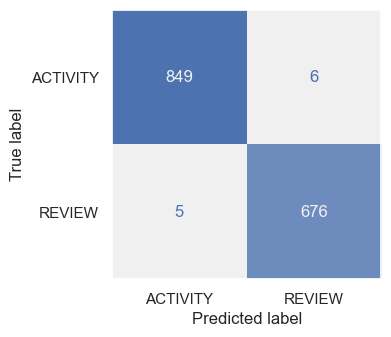

In [34]:
cm_display = metrics.ConfusionMatrixDisplay.from_predictions(
    y_true,
    y_pred,
    display_labels=test_dataset.classes,
    colorbar=False,
    xticks_rotation=0,
    cmap=sns.color_palette('light:b', as_cmap=True)
)
cm_display.ax_.grid(False)
cm_display.figure_.set_size_inches(3.5, 3.5)

Замечательная модель по метрикам:

In [35]:
print(metrics.classification_report(y_true, y_pred, target_names=test_dataset.classes, zero_division=True))

              precision    recall  f1-score   support

    ACTIVITY       0.99      0.99      0.99       855
      REVIEW       0.99      0.99      0.99       681

    accuracy                           0.99      1536
   macro avg       0.99      0.99      0.99      1536
weighted avg       0.99      0.99      0.99      1536



Демонстрация работы модели:

In [36]:
net.eval()
for i in torch.randperm(len(test_dataset))[:5]:
    x, y = test_dataset[i]
    x, y = x.to(DEVICE), y.to(DEVICE)
    pred = net(x.unsqueeze(0))

    pred_proba, pred_label_indices = torch.softmax(pred, 1).topk(min(len(test_dataset.classes), 3), dim=1)
    pred_labels = test_dataset.encoder.inverse_transform(pred_label_indices.squeeze().cpu())
    predicts = ", ".join([f"{label} ({prob:.2f})" for (label, prob) in zip(pred_labels, pred_proba.squeeze())])

    text = test_dataset.texts[i]
    text = text if len(text) < 80 else text[:80] + "..."
    target = test_dataset.encoder.inverse_transform([y.cpu()])[0]

    print(f"Input:   {text}")
    print(f"Target:  {target}")
    print(f"Predict: {predicts}\n")

Input:   concert keep wife never get know freddie mercury alive learnt people present int...
Target:  REVIEW
Predict: REVIEW (1.00), ACTIVITY (0.00)

Input:   beach warm stay warm drinking eggnog
Target:  ACTIVITY
Predict: ACTIVITY (1.00), REVIEW (0.00)

Input:   well romantic spiritual sexy korean movie ever see couple scene would consider r...
Target:  REVIEW
Predict: REVIEW (1.00), ACTIVITY (0.00)

Input:   skiing snow mobiling ice skate
Target:  ACTIVITY
Predict: ACTIVITY (1.00), REVIEW (0.00)

Input:   bath run sleep
Target:  ACTIVITY
Predict: ACTIVITY (1.00), REVIEW (0.00)

